In [10]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
%matplotlib inline
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [11]:
import datetime

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1900, 1, 1)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

In [12]:
fls1 = glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.txt')
fls2= glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.TXT')
fls_all = fls1[:1] + fls2[:5] + fls2[6:]

In [13]:
def construct_feature_matrix(fls_all):
    '''
    Constructs a feature matrix after some data cleaning
    '''
    dfs = []
    for fl in fls_all:
        df = pd.read_csv(fl)
        col_name = df.columns[1]
        df['date'] = df['Lookup'].apply(xldate_to_datetime)
        df = df.drop('Lookup', axis=1)
        df = df.set_index(keys='date')
        dfs.append(df)

    feature_matrix = pd.concat([df for df in dfs], join='inner', axis=1)
    feature_matrix = feature_matrix.dropna()
    
    return feature_matrix




In [14]:
def clean_target(path):
    targets = pd.read_csv(path)
    targets['date'] = targets['Lookup'].apply(xldate_to_datetime)
    targets = targets.set_index(keys='date').drop('Lookup', axis=1).dropna()
    return targets

In [6]:
feature_matrix = construct_feature_matrix(fls_all)
features = feature_matrix.columns
targets = clean_target('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
features_targets = pd.concat([feature_matrix, targets], join='inner', axis = 1)
features_targets = features_targets.dropna(axis=0)
split = int(len(features_targets) * .6)

In [15]:
fc= []
for key in feature_matrix.columns:
    fc.append(tf.contrib.layers.real_valued_column(key.replace('%', '').replace('-', '').replace(' ', '') , dimension=1))

In [16]:
fc

[_RealValuedColumn(column_name='SectorCorrBD126', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='10002000Sharpe', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='Diff10DayMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AwayFrom200dMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='VolDistfrom21dMAofVol', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='LaggedADvs.10dMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='21dMAofBreakdown', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='EMUSASharpe', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)]

In [17]:
def get_data():
    
    feature_cols = {k.replace('%', '').replace('-', '').replace(' ', '') : tf.constant(v.values) for k,v in idata[cols].items()}
    labels = tf.constant((idata[day].values > 0).astype(int))
    return feature_cols, labels                         
                          
model = tf.contrib.learn.DNNClassifier(feature_columns=fc,
                    n_classes=2, hidden_units=[100, 100])

In [19]:
model

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x1c1befef60>, 'hidden_units': [100, 100], 'feature_columns': (_RealValuedColumn(column_name='SectorCorrBD126', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='10002000Sharpe', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Diff10DayMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AwayFrom200dMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='VolDistfrom21dMAofVol', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LaggedADvs.10dMA', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='21dMAofBreakdown', dimension=1, default_value=None, dtype=tf.float32, normalizer=N

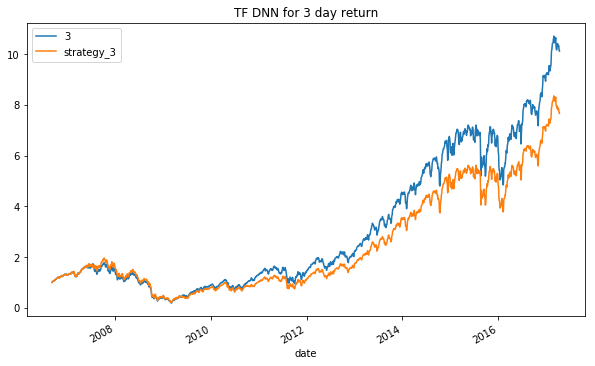

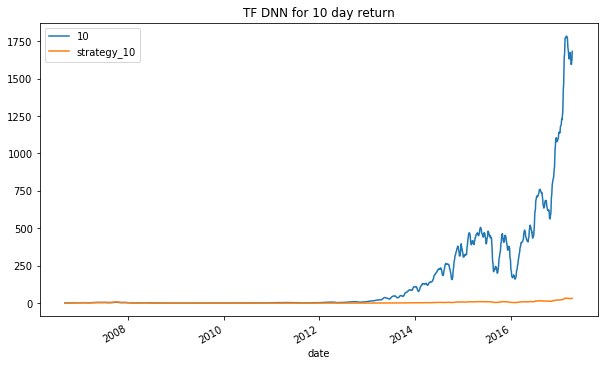

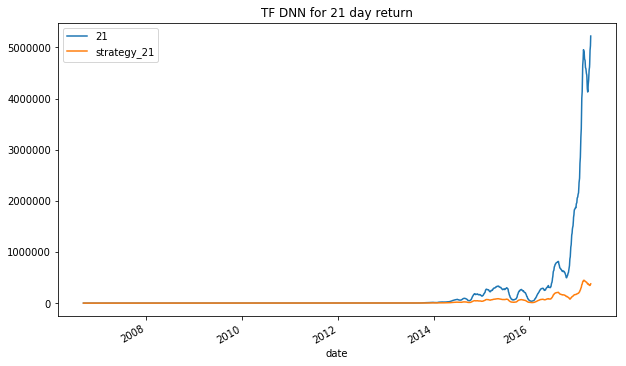

In [20]:
cols = feature_matrix.columns
training_data = features_targets[:split].copy() 
test_data = features_targets[split:].copy() 

for day in ['3', '10', '21']:
    idata = training_data
    #print(len(idata))
    model.fit(input_fn=get_data, steps=500, )
    idata = test_data
    evaluate = model.evaluate(input_fn=get_data, steps=1)
    #print(len(idata))
    pred = np.array(list(model.predict(input_fn=get_data)))
    #print(len(pred))
    #print(len(test_data))
    test_data['prediction_{}'.format(day)] = np.where(pred > 0, 1, -1)
    test_data['strategy_{}'.format(day)] = test_data['prediction_{}'.format(day)] * test_data[day]
    ax = test_data[[day, 'strategy_{}'.format(day)]].cumsum(
                  ).apply(np.exp).plot(figsize=(10, 6));
    
    ax.set_title('TF DNN for {} day return'.format(day))